In [7]:
import pandas as pd
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [8]:
GOLDEN_DATA = [
    ["We price the swap at 54 bips", {"We price": "RFQ", "swap":"FIN_PRODUCT", "54 bips":"CARDINAL"}, 'FINANCIAL'],
    ["TD offers 1.123 on 10 million of CADUSD", {"TD offers": "RFQ", "CADUSD":"CURRENCY_PAIR", "1.123":"CARDINAL", '10 million':"CARDINAL"}, 'FINANCIAL'],
    ["Names like AMZN trade frequently but tech like TWLO trades on lower volume", {'TWLO':"EQUITY_SYMBOL", 'AMZN':'EQUITY_SYMBOL'}, 'FINANCIAL'],
    ["TD bids 99.91 on US 10s. Done. Thanks for the trade. Confirm to follow", {'TD bids':"RFQ", 'Done.':'TRADE_EXECUTION', 'Thanks for the trade':'TRADE_EXECUTION', 'Confirm to follow':'TRADE_EXECUTION'}, 'FINANCIAL'],
    ["Amazon (AMZN) is trading 13% higher than 12 months ago but 22% lower than the peak", {'AMZN':"EQUITY_SYMBOL"}, 'FINANCIAL'],
    ["The river Amazon flows mostly through Brazil", {}, 'NON-FINANCIAL']
]

In [13]:
df = pd.DataFrame(data=GOLDEN_DATA, columns=['Text', 'dropme', 'Classification']).drop('dropme', axis=1)
df.head()

,Text,Classification
0,We price the swap at 54 bips,FINANCIAL
1,TD offers 1.123 on 10 million of CADUSD,FINANCIAL
2,Names like AMZN trade frequently but tech like...,FINANCIAL
3,TD bids 99.91 on US 10s. Done. Thanks for the ...,FINANCIAL
4,Amazon (AMZN) is trading 13% higher than 12 mo...,FINANCIAL


In [17]:
df['Classification'].nunique()

2

In [48]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.33, random_state=42)

In [49]:
print('Test sample:', train['Text'].iloc[0])
print('Classification:', train['Classification'].iloc[0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

Test sample: The river Amazon flows mostly through Brazil
Classification: NON-FINANCIAL
Training Data Shape: (4, 2)
Testing Data Shape: (2, 2)


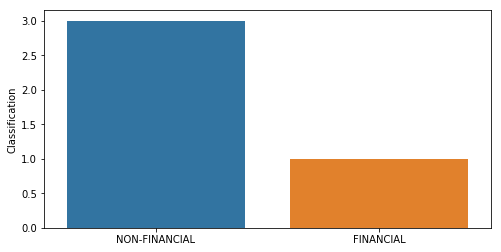

In [50]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = train['Classification'].unique(), y=train['Classification'].value_counts())
plt.show()

In [51]:
import spacy

nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [52]:
test.head()

,Text,Classification
0,We price the swap at 54 bips,FINANCIAL
1,TD offers 1.123 on 10 million of CADUSD,FINANCIAL


In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import string
import re
import spacy
# spacy.load('en')
from spacy.lang.en import English
parser = English()

In [54]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

In [55]:
class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        a = [cleanText(text) for text in X]
#         print(a)
        return a
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
#     print(tokens)
    return tokens

In [63]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        pass #print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        pass #print(feat)

vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

# data
train1 = train['Text'].tolist()
labelsTrain1 = train['Classification'].tolist()

test1 = test['Text'].tolist()
labelsTest1 = test['Classification'].tolist()
# train
pipe.fit(train1, labelsTrain1)

# test
preds = pipe.predict(test1)
# print("accuracy:", accuracy_score(labelsTest1, preds))
# print("Top 10 features used to predict: ")

printNMostInformative(vectorizer, clf, 10)

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names()

for i in range(len(train1)):
    print(i, train1[i], labelsTrain1[i])
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    print(indexIntoVocab)
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    print(numOccurences)
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))
    break

Class 1 best: 
Class 2 best: 
0 The river Amazon flows mostly through Brazil NON-FINANCIAL
[ 9 11  6 19]
[1 1 1 1]


In [65]:
preds = transform.predict(test1)

AttributeError: predict not found

In [57]:
train1[1]

'Names like AMZN trade frequently but tech like TWLO trades on lower volume'

In [58]:
# vocab[1913], vocab[1347], vocab[123]

In [59]:
from sklearn import metrics
print(metrics.classification_report(labelsTest1, preds, 
                                    target_names=df['Classification'].unique()))

               precision    recall  f1-score   support

    FINANCIAL       1.00      0.50      0.67         2
NON-FINANCIAL       0.00      0.00      0.00         0

    micro avg       0.50      0.50      0.50         2
    macro avg       0.50      0.25      0.33         2
 weighted avg       1.00      0.50      0.67         2



/Library/Frameworks/Python.framework/Versions/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Library/Frameworks/Python.framework/Versions/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Library/Frameworks/Python.framework/Versions/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [80]:
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])
# data
train1 = train['Text'].tolist()
labelsTrain1 = train['Classification'].tolist()
test1 = test['Text'].tolist()
labelsTest1 = test['Classification'].tolist()
# train
pipe.fit(train1, labelsTrain1)
# test
preds = pipe.predict(test1)


preds = pipe.predict(["amazon"])
print("*****")
# print(test1)
print("*****")
print(preds)

# print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")

printNMostInformative(vectorizer, clf, 10)
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names()
for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

*****
*****
['NON-FINANCIAL']
Top 10 features used to predict: 
Class 1 best: 
(-0.253799363849912, 'trade')
(-0.1207442621539155, 'amzn')
(-0.1207442621539155, 'low')
(-0.10164198107206239, '10s')
(-0.10164198107206239, '99.91')
(-0.10164198107206239, 'bid')
(-0.10164198107206239, 'confirm')
(-0.10164198107206239, 'follow')
(-0.10164198107206239, 'td')
(-0.10164198107206239, 'thank')
Class 2 best: 
(0.23849441719428124, 'river')
(0.23849441719428124, 'flow')
(0.23849441719428124, 'brazil')
(0.14916327566429988, 'amazon')
(-0.03141312062393412, 'volume')
(-0.03141312062393412, 'twlo')
(-0.03141312062393412, 'tech')
(-0.03141312062393412, 'frequently')
(-0.06282624124786824, 'like')
(-0.08933114152998138, 'peak')
